In [1]:
# Library imports
import scipy
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def evaluate(t, y):
    NBodies = int(len(y)/6)
    accelerations = np.zeros(y.size)
    
    for i in range(NBodies):
        ioffset = i*6
        
        for j in range(NBodies):
            joffset = j*6
            accelerations[ioffset:ioffset+3] = y[ioffset+3:ioffset+6]
            
            if i != j:
                d = y[ioffset:ioffset+3] - y[joffset:joffset+3]
                r = np.sqrt(np.sum(d**2))
                a = d*G*masses[j]/(r**3)
                accelerations[ioffset+3:ioffset+6] += a
    
    return accelerations

In [3]:
def euler(t,dt,y,evaluate):
    k = dt * evaluate(t, y) 
    y_new = y + k
    
    return y_new

In [4]:
def getVelocities(y):
    NBodies = int(len(y)/6)
    velocities = np.zeros(y.size)
    
    for i in range(NBodies):
        ioffset = i*6
        
        for j in range(NBodies):
            joffset = j*6
            velocities[ioffset:ioffset+3] = y[ioffset+3:ioffset+6]
            
    return velocities

In [5]:
def getAcceleration(t, y): #Returns vector of 0 in v, a in acc
    NBodies = int(len(y)/6)
    accelerations = np.zeros(y.size)
    
    for i in range(NBodies):
        ioffset = i*6
        
        for j in range(NBodies):
            joffset = j*6
            accelerations[ioffset:ioffset+3] = 0
            
            if i != j:
                d = y[ioffset:ioffset+3] - y[joffset:joffset+3]
                r = np.sqrt(np.sum(d**2))
                a = d*G*masses[j]/(r**3)
                accelerations[ioffset+3:ioffset+6] += a
    
    return accelerations


In [6]:
def rk4(t,dt,y,evaluate):
    k1 = dt * evaluate(t, y) 
    k2 = dt * evaluate(t + 0.5*dt, y + 0.5*k1)
    k3 = dt * evaluate(t + 0.5*dt, y + 0.5*k2)
    k4 = dt * evaluate(t + dt, y + k3)
    
    y_new = y + (1/6)*(k1+ 2*k2 + 2*k3 + k4)
    
    return y_new

In [7]:
def LeapFrog(t, dt, y):
    y_new = y + getAcceleration(t, y)*dt/2
    
    y_new =y_new + getVelocities(y_new) * dt
    
    y_new = y_new + getAcceleration(t, y_new)*dt/2
    
    return y_new

In [8]:
def AdamsBashforth(t,dt,y,evaluate):
    w0 = y[0]
    w1 = y[1]
    w2 = y[2]
    w3 = y[3]
    
    t0 = t - 4*dt
    t1 = t - 3*dt
    t2 = t - 2*dt
    t3 = t - dt
    
    w = w3 + (dt/24)*(55*evaluate(t3, w3) - 59*evaluate(t2, w2) + 37*evaluate(t1, w1) - 9*evaluate(t0, w0))
    
    return w

In [9]:
def AdamsMoulton(t,dt,y,evaluate):
    w1 = y[1]
    w2 = y[2]
    w3 = y[3]
    w4 = y[4]
    
    t1 = t - 3*dt
    t2 = t - 2*dt
    t3 = t - 1*dt
    t4 = t
    
    w4 = w3 + (dt/24)*(9*evaluate(t4, w4) + 19*evaluate(t3, w3) - 5*evaluate(t2, w2) + evaluate(t1, w1))
    
    return w4

In [10]:
def runRK4(T, dt, y0, masses, evaluate, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    energy = np.empty((nsteps+1, 2))
    
    history[0, :] = y0
    energy[0,:] = getEnergyAndAMomentum(y0, masses)
    
    t = t0
    for i in range(nsteps):
        history[i+1] = rk4(t, dt, history[i,:], evaluate)
        energy[i+1,:] = getEnergyAndAMomentum(history[i+1],masses)
        t += dt
    
    return history, energy

In [11]:
def runEuler(T, dt, y0, masses, evaluate, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    energy = np.empty((nsteps+1, 2))
    
    history[0, :] = y0
    energy[0,:] = getEnergyAndAMomentum(y0, masses)
    
    t = t0
    for i in range(nsteps):
        history[i+1] = euler(t, dt, history[i,:], evaluate)
        energy[i+1,:] = getEnergyAndAMomentum(history[i+1],masses)
        t += dt
    
    return history, energy

In [12]:
def runLeapFrog(T, dt, y0, masses, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    energy = np.empty((nsteps+1, 2))
    
    history[0, :] = y0
    energy[0,:] = getEnergyAndAMomentum(y0, masses)
    
    t = t0
    for i in range(nsteps):
        history[i+1] = LeapFrog(t, dt, history[i,:])
        energy[i+1,:] = getEnergyAndAMomentum(history[i+1],masses)
        t += dt

    return history, energy

In [13]:
def runAB(T, dt, y0, masses, evaluate, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    energy = np.empty((nsteps+1, 2))
    
    history[0, :] = y0
    energy[0,:] = getEnergyAndAMomentum(y0, masses)
    
    t = t0
    for i in range(3):
        history[i+1] = rk4(t, dt, history[i,:], evaluate)
        energy[i+1,:] = getEnergyAndAMomentum(history[i+1],masses)
        t += dt
        
    for i in range(3, nsteps):
        history[i+1] = AdamsBashforth(t, dt, history[i-3:i+1,:], evaluate)
        energy[i+1,:] = getEnergyAndAMomentum(history[i+1],masses)
        t += dt
    
    return history, energy

In [14]:
def runAM(T, dt, y0, masses, evaluate, historyAux, t0 = 0):
    nsteps = int((T-t0)/dt)
    history = np.empty((nsteps+1, len(y0)))
    energy = np.empty((nsteps+1, 2))
    
    history[0, :] = y0
    energy[0,:] = getEnergyAndAMomentum(y0, masses)
    
    t = t0
    for i in range(3):
        history[i+1] = rk4(t, dt, history[i,:], evaluate)
        energy[i+1,:] = getEnergyAndAMomentum(history[i+1],masses)
        t += dt
        
    for i in range(3, nsteps):
        history[i+1] = AdamsMoulton(t, dt, historyAux[i-3:i+2,:], evaluate) 
        energy[i+1,:] = getEnergyAndAMomentum(history[i+1],masses)
        t += dt
    
    return history, energy

In [15]:
def runPredictorCorrector(T, dt, y0, masses, evaluate, t0 = 0):
    historyAB, e = runAB(T+dt, dt, y0, masses, evaluate)
    history, energy = runAM(T, dt, y0, masses, evaluate, historyAB)
    return history, energy

In [16]:
def getEnergyAndAMomentum(y, masses):
    v = getVelocities(y).copy().reshape((-1,6))[:,:3]
    m = masses.copy().reshape((-1,1))
    KE = 0.5 * np.sum(np.sum( m * v**2 ))
    
    
    yAux = y.copy().reshape((-1,6))
    
    
    x = yAux[:,0].reshape(-1, 1)
    y = yAux[:,1].reshape(-1, 1)
    z = yAux[:,2].reshape(-1, 1)
    
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z
    
    
    inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
    inv_r[inv_r>0] = 1.0/inv_r[inv_r>0]

    PE = -G * np.sum(np.sum(np.triu(-(m*m.T)*inv_r,1)))
    
    
    return KE, PE

In [17]:
def showSimulation(history, energy, projection):
    
    for method in history:
        nBodies = int(len(history[method][0])/6)
        if projection == '2d':
            fig = plt.figure()
            fig.suptitle('Prediction with ' + method + ' method', fontsize=16)
            ax = plt.axes()
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            for i in range(nBodies):
                ax.plot(history[method][:,i*6], history[method][:,i*6 + 1])
                
        elif projection == '3d':
            fig = plt.figure()
            fig.suptitle('Prediction with ' + method + ' method', fontsize=16)
            ax = plt.axes(projection='3d')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z');
            for i in range(nBodies):
                ax.plot3D(history[method][:,i*6], history[method][:,i*6 + 1], history[method][:,i*6 + 2])
        
        plt.figure(figsize = (5,5))
        plt.plot(energy[method][:500,0]+energy[method][:500,1], 'y', label = 'Total Energy')
        plt.plot(energy[method][:500,1], 'r', label = 'PE')
        plt.plot(energy[method][:500,0], 'b', label = 'KE')
        plt.xlabel("Iterations")
        plt.ylabel("Energy(J)")
        plt.legend(loc="best")
        plt.show()
    
    
    return 

In [18]:
# Variable declaration 1 -> Earth and Moon
G = -6.67*(10**-11)
t0 = 0
T = 6.221e6-6.67
dt = 3600 
y0 = np.array([3.84e8, 0, 0, 0, 1000, 0,
               0, 0, 0, 0, 0, 0])
masses = np.array([7.347e22, 5.97e24])

In [19]:
# Variable declaration 2 -> Saturn, Janus and Epithemeus
G = -6.67*(10**-20)
t0 = 0
T = 6.221e6
dt = 360
y0 = np.array([0, 0, 0, 0, 0, 0,                                  #Saturn
               0.11e6, 0.93e5, -0.17e5, -0.99e1, 0.12e2, -0.8e-1, #Janus
              0.19e5, -0.14e6,0.15e5,0.16e2, 0.17e1, -0.15e1])    #Epithemeus
masses = np.array([5.68e26, 1.89e18, 5.26e17])

In [20]:
# Variable declaration 3 -> Solar system
G = -6.67*(10**-11)
t0 = 0
T = 6.221e9
dt = 360000
y0 = np.array([0,0,0,0,0,0,                                                                     #Sun
              -3.166e+011,6.696e+011,4.297e+009,-1.239e+004,-5.861e+003, 3.020e+002,            #Jupyter
              -1.210e+012,-5.941e+011,5.844e+010,4.487e+003,-9.141e+003,-18.731,                #Saturn
              -1.147e+012,-2.483e+012,5.772e+009,6.469e+003,-2.990e+003,-94.58104783662382,     #Uranus
              -4.451e+012, 2.582e+011,9.730e+010, -3.146e+002,-5.468e+003,1.196e+002,           #Neptune
              -4.215e+012, -5.323e+011, 1.276e+012, 8.805e+002, -6.035e+003, 3.912e+002])       #Pluto
masses = np.array([1.9891e30, 18986e23, 5684.6e23, 868.32e23, 1024.3e23, 0.1314e23])

In [23]:
# Variable declaration 4 -> figure 8
G = -1
t0 = 0
T = 5
dt = 0.01
y0 = np.array([0.97000436, -0.24308753, 0,  0.93240737/2, 0.86473146/2, 0,
                -0.97000436, 0.24308753,0, 0.93240737/2, 0.86473146/2, 0,
                0,0,0,-0.93240737,  -0.86473146,0])
masses = np.array([1, 1, 1])

In [24]:
# Calculation aux
history = {}
energy = {}
history['Runge Kutta 4'], energy['Runge Kutta 4'] = runRK4(T, dt, y0, masses, evaluate)
history['Euler'], energy['Euler'] = runEuler(T, dt, y0, masses, evaluate)
history['Leap Frog'], energy['Leap Frog'] = runLeapFrog(T, dt, y0, masses)
history['Adams Bashforth'], energy['Adams Bashforth'] = runAB(T, dt, y0, masses, evaluate)
history['Predictor Corrector'], energy['Predictor Corrector'] = runPredictorCorrector(T, dt, y0, masses, evaluate)

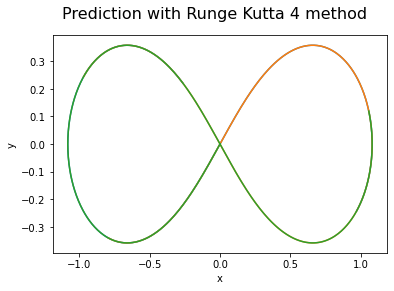

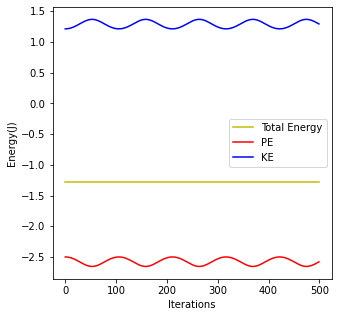

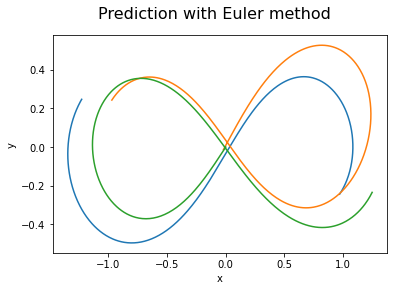

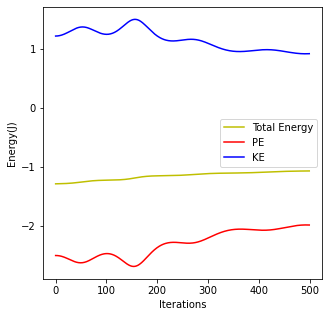

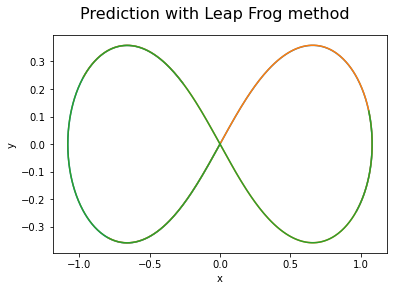

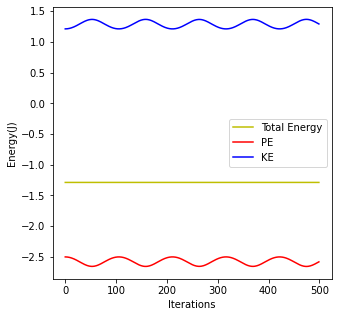

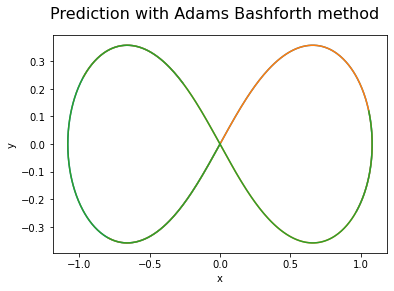

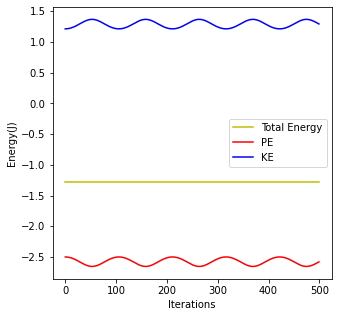

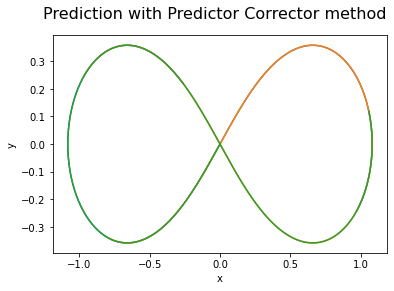

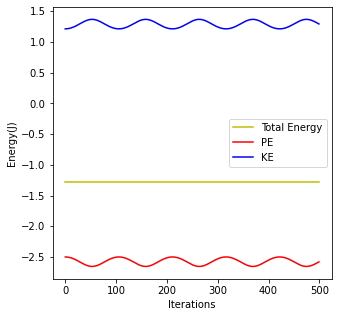

In [26]:
showSimulation(history, energy, '2d')

In [24]:
energy['Runge Kutta 4'][:15,:]

array([[ 3.67350000e+28, -7.61866680e+28],
       [ 3.67351665e+28, -7.61868346e+28],
       [ 3.67356661e+28, -7.61873341e+28],
       [ 3.67364987e+28, -7.61881667e+28],
       [ 3.67376642e+28, -7.61893323e+28],
       [ 3.67391627e+28, -7.61908307e+28],
       [ 3.67409940e+28, -7.61926620e+28],
       [ 3.67431580e+28, -7.61948260e+28],
       [ 3.67456546e+28, -7.61973227e+28],
       [ 3.67484838e+28, -7.62001518e+28],
       [ 3.67516452e+28, -7.62033133e+28],
       [ 3.67551388e+28, -7.62068069e+28],
       [ 3.67589645e+28, -7.62106325e+28],
       [ 3.67631218e+28, -7.62147899e+28],
       [ 3.67676108e+28, -7.62192788e+28]])

In [26]:
a = np.array([[1, 2, 3],[4, 5, 6], [7, 8, 9]])
np.triu(a, 1)

array([[0, 2, 3],
       [0, 0, 6],
       [0, 0, 0]])